## Text classification with classifier algorithms in Scikit-learn along Boosting Classifiers for Imbalanced data

###### As per the Requirements from the mentor - To perform Text classification on the provided datasets using various classifiers on the same
### Project flow :
1. Data collections and Data Overiview
   - Recieved the dataset via mail consisting of 5 different emotions labelled on the different texts
   - Using wordcloud , matplotlib , other methods views the data
2. Text Preprocessing
   - Removal of Links and html tags
   - Removal of punctuations and converting to lowercase
   - Removal of slangs and expansions of contracts
   - Removal of stop words 
   - Lemmatization
3. Text Representation **Vectorization** 
   - **TF-IDF(Term FreQuency-Inverse Document Frequency)**
4. Handling Imbalanced Data 
   - Using customer oversampling(random selection/duplicating it)
   - Using SMOTE **(Synthentic minority Oversampling technique)**
5. Modelling
   -  Dividing **Train(70%),Test(20%),validate(10%)** data for both balanced and imbalanced dataset
   - Modelling On the Imbalanced Dataset
   - Modelling On the Balanced Dataset
   - **GridSearchCV** for Hyper paramter tuning
6. Analysis of classifiers
   - View of Confusion matrix 
   - Saving the report of classifier in the csv file
7. Conclusion 

**Importing libraries and Packages**

In [115]:
# to handle and view the datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
import nltk

# for text preprocessing
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re,string,unicodedata

# For spliting and evalution imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,mean_absolute_error
from sklearn.model_selection import train_test_split

from collections import Counter
  
# for text representation 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Different Classifier imports from scikit-learn
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# For transformer classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from string import punctuation
from nltk import pos_tag
from nltk import pos_tag
from nltk.corpus import wordnet
import re
import warnings

In [ ]:
# using the pip command to install the packages
!pip install xgboost
!pip install imblearn
!pip install lightgbm
!pip install --upgrade threadpoolctl
!pip install --upgrade imbalanced-learn
!pip install scikit-learn==1.4.2

In [3]:
# reading the dataset and labels provided by mentor
emotion_df = pd.read_csv(r"D:\Sentiment_InfosysIntern\lakshita\SentimentAnalysis-TextClassification\Emotions_training.csv",encoding='latin-1')
emotion_labels = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

### Data Overview

In [4]:
emotion_df.info() # described the different column and its constraints 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [5]:
emotion_df['label'].unique() # check for any disimilar labels

array([0, 3, 2, 5, 4, 1], dtype=int64)

In [6]:
emotion_df.isnull().sum() # check for any null rows

text     0
label    0
dtype: int64

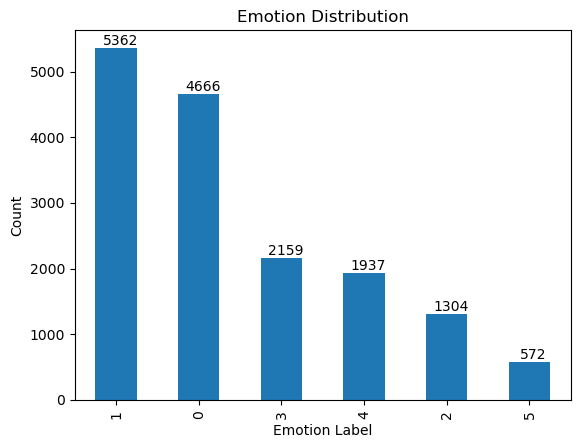

In [7]:
bars = emotion_df.label.value_counts().plot(kind='bar')
for container in bars.containers:
    for bar in container:
        yval = bar.get_height()
    #  text label above the bar with some offset
        plt.text(bar.get_x() + 0.3, yval + 0.2, round(yval, 2), ha='center', va='bottom')  

plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.title("Emotion Distribution")
plt.show()

- The majority class is 1 while the minority are 0,3,4,2,5 ,**exist class imbalance in the dataset**

**Using world cloud lets see the distribution of different occuring words**

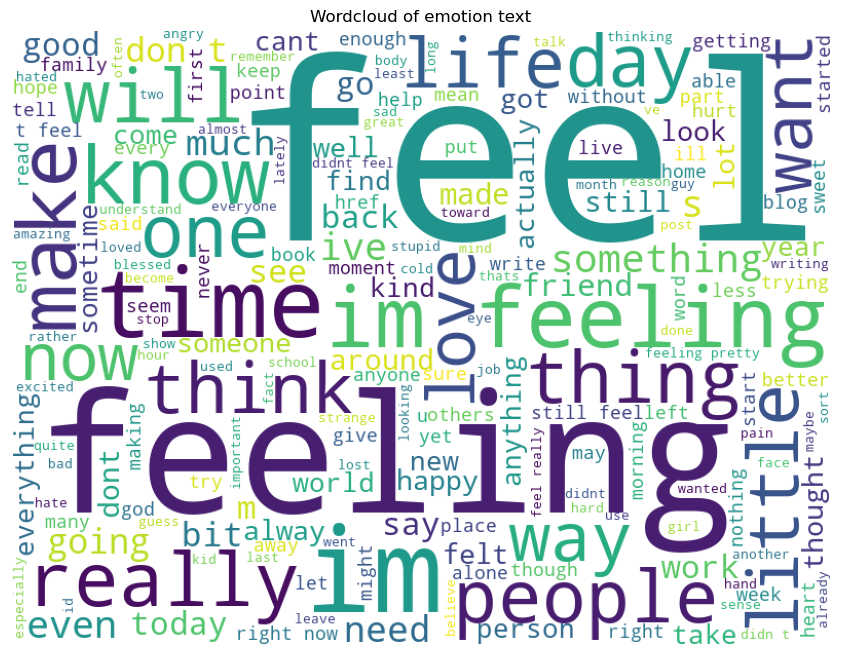

In [8]:
## Data preprocessing on text
wordcloud = WordCloud(width=800, height=600, background_color="white")

wordcloud.generate(" ".join(emotion_df['text']))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud of emotion text")
plt.show()


### Text Preprocessing on the "text" column

In [9]:
emotion_df['text']=emotion_df['text'].str.lower()

In [10]:
# Using stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.remove("not") # since not can play a major role in difference
stop_words=set(stop_words)


In [11]:
# for the slang expansions(although there is no slang usage in the dataset , it is a good practice to make sure the removal of slangs)
def create_slang_dictionary(filename): 
    chart_words = {}
    with open(filename, 'r') as file:
        for line in file:
            # Remove trailing newline character
            line = line.strip()
            # Split the line on the equals sign (=)
            abbreviation, meaning = line.split('=')
            chart_words[abbreviation] = meaning
    return chart_words

 
filename = r"D:\Sentiment_InfosysIntern\data_preprocessing\slang.txt" # recieved the file through exploration in net for data preprocessing
chart_words = create_slang_dictionary(filename)
print(chart_words) # set of slang and their expansion to it

{'AFAIK': 'As Far As I Know', 'AFK': 'Away From Keyboard', 'ASAP': 'As Soon As Possible', 'ATK': 'At The Keyboard', 'ATM': 'At The Moment', 'A3': 'Anytime, Anywhere, Anyplace', 'BAK': 'Back At Keyboard', 'BBL': 'Be Back Later', 'BBS': 'Be Back Soon', 'BFN': 'Bye For Now', 'B4N': 'Bye For Now', 'BRB': 'Be Right Back', 'BRT': 'Be Right There', 'BTW': 'By The Way', 'B4': 'Before', 'CU': 'See You', 'CUL8R': 'See You Later', 'CYA': 'See You', 'FAQ': 'Frequently Asked Questions', 'FC': 'Fingers Crossed', 'FWIW': "For What It's Worth", 'FYI': 'For Your Information', 'GAL': 'Get A Life', 'GG': 'Good Game', 'GN': 'Good Night', 'GMTA': 'Great Minds Think Alike', 'GR8': 'Great', 'G9': 'Genius', 'IC': 'I See', 'IDK': 'I Do not know', 'ICQ': 'I Seek you', 'ILU': 'I Love You', 'IMHO': 'In My Honest/Humble Opinion', 'IMO': 'In My Opinion', 'IM': 'I am', 'IOW': 'In Other Words', 'IRL': 'In Real Life', 'KISS': 'Keep It Simple, Stupid', 'LDR': 'Long Distance Relationship', 'LMAO': 'Laugh', 'LOL': 'Laugh

### Text cleaning using pipeling by functions

In [12]:
# remove existing html tags
def remove_html_tags(text): 
    pattern=re.compile('<.*?>')
    return pattern.sub(r'',text)

# removes punctuations
def remove_special_character(content): 
    return re.sub(r'[^a-zA-Z ]',' ', content )

#Removal of URLs
def remove_url(content): 
    return re.sub(r'http\S+', '', content)

# remove of stop words from text
def remove_stopwords(content):
    clean_data = []
    for i in content.split():
        if i.strip().lower() not in stop_words and i.strip().lower().isalpha():
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)

#Slang expansions
def replace_string(text,chart_words): 
    words = text.split()
    new_words = []
    for word in words:
        if word.upper() in chart_words:
            new_words.append(chart_words[word.upper()])  
        else:
            new_words.append(word)
    return " ".join(new_words)  

In [13]:
# for the expansions of certain contract usage in text
def contraction_expansion(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "can not", content)
    content = re.sub(r"don\'t", "do not", content)
    content = re.sub(r"shouldn\'t", "should not", content)
    content = re.sub(r"needn\'t", "need not", content)
    content = re.sub(r"hasn\'t", "has not", content)
    content = re.sub(r"haven\'t", "have not", content)
    content = re.sub(r"weren\'t", "were not", content)
    content = re.sub(r"mightn\'t", "might not", content)
    content = re.sub(r"didn\'t", "did not", content)
    content = re.sub(r"n\'t", " not", content)
    return content
    

**Data cleaning action takes place using above functions**

In [14]:
def data_cleaning(content):
    if not pd.isna(content):  # Check for missing values (NaN) Issue solved as removed the null rows periviously 
        content = remove_html_tags(content)
        content = remove_url(content)
        content = remove_special_character(content)
        content = contraction_expansion(content)
        content = replace_string(content,chart_words) # Expanded form
        content = remove_stopwords(content)
    return content

In [15]:
emotion_df['text']=emotion_df['text'].apply(data_cleaning)

Using **lemmatization** on the 'text' column after cleaning

In [16]:
# Lemmatization from nltk package
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
emotion_df['text'] = emotion_df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [17]:
emotion_df['text'][895]

'male stupid first woman cry baby get feel really cool putting stupid men place'

**lets see the distribution of occuring words after text preprocessing**

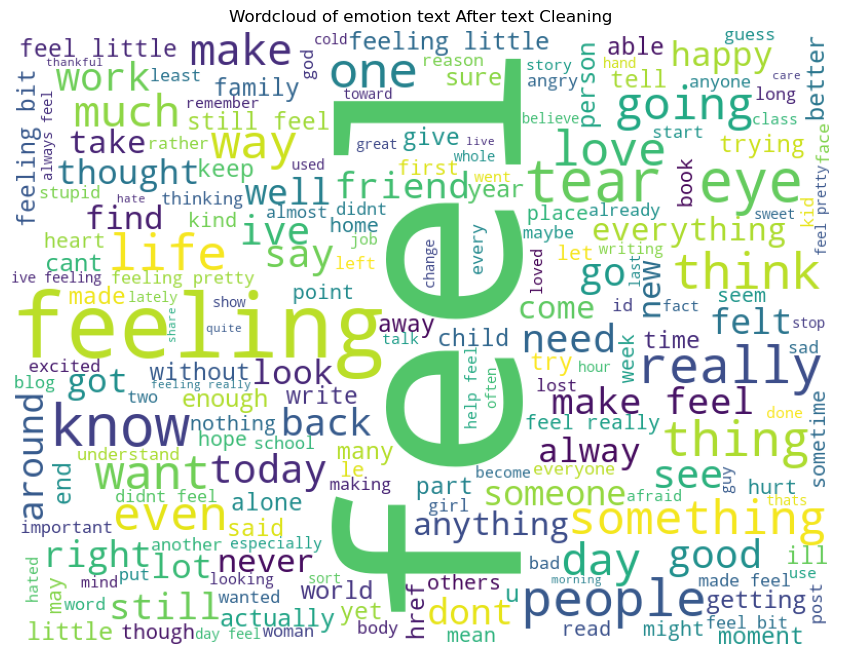

In [18]:

wordcloud = WordCloud(width=800, height=600, background_color="white")
wordcloud.generate(" ".join(emotion_df['text']))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud of emotion text After text Cleaning")
plt.show()

- Although there is no change as in the pervious one it is recommended to perform the text cleaning initally

**Lets see the Distrubution of Text Lengths**

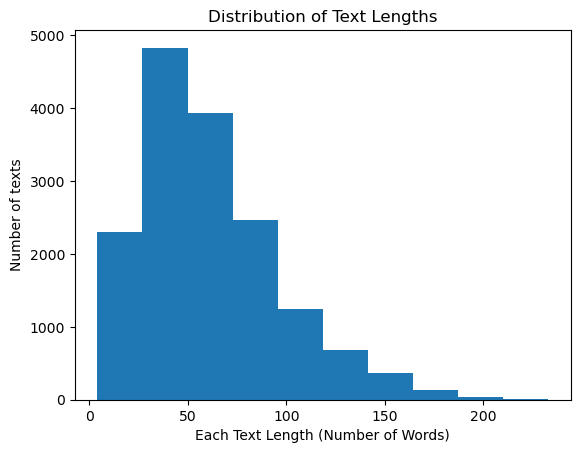

In [19]:
plt.xlabel("Each Text Length (Number of Words)")  
plt.ylabel("Number of texts")  
plt.title("Distribution of Text Lengths")  
plt.hist(emotion_df['text'].str.len()) # through Histogram also we can view the text Length distribution
plt.show()

##### Dataset After performing Text preprocessing

In [20]:
emotion_df

,text,label
0,didnt feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,2
4,feeling grouchy,3
...,...,...
15995,brief tear eye beanbag said anna feel like beaten,0
15996,turning feel pathetic still waiting table subb...,0
15997,feel strong good overall,1
15998,feel like rude comment glad,3


## Handling multi-class  Imbalance in the Dataset

**Custome creation of Oversampling method using Duplications(with help of dataframe sample() to pick random record and duplicate it)**

In [21]:
class_counts = emotion_df['label'].value_counts()
majority_class = class_counts.idxmax()  # the majority class

# Function to oversample a class
def oversample_class(data_subset, target_count):
  # Randomly sample additional data points to reach target count
    oversampled_data = data_subset.sample(replace=True, n=target_count - len(data_subset))
    return pd.concat([data_subset, oversampled_data])

# Oversample minority classes
oversampled_data = []
for label, count in class_counts.items():
    if label != majority_class: # ecxcept majority class 1 , others get to oversample
        data_subset = emotion_df[emotion_df['label'] == label]  # Filter data for this class
        oversampled_subset = oversample_class(data_subset, class_counts[majority_class])  # Oversample to majority class count
        oversampled_data.append(oversampled_subset)
    else:
        oversampled_data.append(emotion_df[emotion_df['label'] == label])  # Keeping majority class as it is

# Combine the oversampled data
oversampled_df = pd.concat(oversampled_data)

# Extracting text and labels from oversampled data
oversampled_text = oversampled_df['text']
oversampled_labels = oversampled_df['label']

<Axes: xlabel='label'>

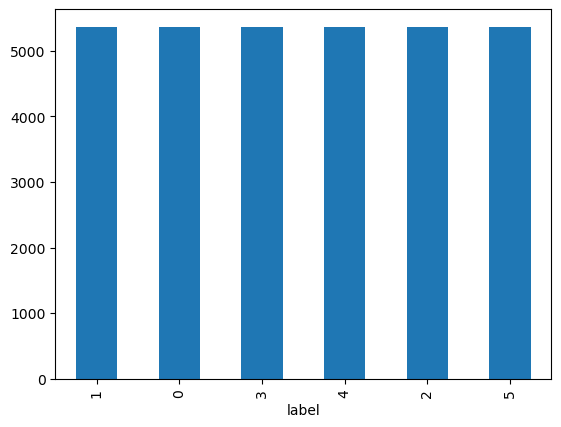

In [22]:
oversampled_labels.value_counts().plot(kind="bar")

 - All the records sizes of each class are equal , hence no imbalance exists

**X,y are used for train and test spliting of dataset**

In [23]:
y = emotion_df['label']  
X  = emotion_df['text']

### Text-Representation(Vectorization) TF-IDF

In [24]:
# vectorization with the balanced dataset
vectorizer = TfidfVectorizer(max_features=2000)  
features_oversampled = vectorizer.fit_transform(oversampled_text) # without imbalance

In [25]:
# vectorization with the balanced dataset using custom oversampling technique
vectorizer = TfidfVectorizer(max_features=2000)  
X_imb_vec = vectorizer.fit_transform(X) # with imbalance

### Dividing the datasets to train data , test data and validate

For the imbalanced dataset split

In [30]:
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imb_vec, y, test_size=0.2, random_state=42,stratify=y)

Dividing the validate dataset from ***x_train_imb*** , ***y_train_imb***

In [31]:
X_train_imb, X_val_imb, y_train_imb, y_val_imb = train_test_split(X_train_imb, y_train_imb, test_size=0.1, random_state=42)

In [107]:
# X_train, X_test, y_train, y_test = train_test_split(features_oversampled, oversampled_df['label'], test_size=0.3, random_state=42,stratify=oversampled_df['label'])
print("X.shape=",X.shape)
print("X_train_imb=",X_train_imb.shape)
print("X_test_imb=",X_test_imb.shape)
print("X_val_imb=",X_val_imb.shape)

X.shape= (16000,)
X_train_imb= (11520, 2000)
X_test_imb= (3200, 2000)
X_val_imb= (1280, 2000)


### Handling imbalance by using the SMOTE

> In **Custom oversampling** Duplicating existing minority class examples can lead to overfitting, where the model learns the specific patterns of those duplicates instead of learning generalizable features.**(poor performance of unseen datas)**

> Where in **SMOTE** ,**Reduces Overfitting**,By introducing **new variations**, SMOTE can help prevent the model from overfitting to the exact duplicates.

In [37]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_syn, y_syn = smote.fit_resample(X_imb_vec, y)

For the Balanced Dataset split

In [38]:
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_syn, y_syn, test_size=0.2, random_state=42,stratify=y_syn)

Dividing the 10% validation from train set split

In [39]:
X_train_syn, X_val_syn, y_train_syn, y_val_syn = train_test_split(X_train_syn, y_train_syn, test_size=0.1, random_state=42)

In [110]:
print("X.shape=",X_syn.shape)
print("X_train_syn=",X_train_syn.shape)
print("X_test_syn=",X_test_syn.shape)
print("X_val_syn=",X_val_syn.shape)

X.shape= (32172, 2000)
X_train_syn= (23163, 2000)
X_test_syn= (6435, 2000)
X_val_syn= (2574, 2000)


<Axes: xlabel='label'>

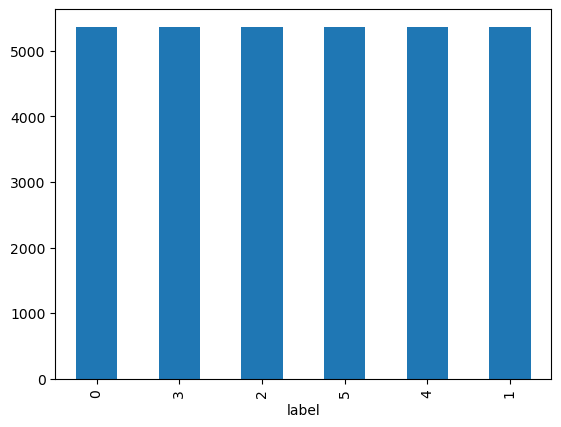

In [40]:
y_syn.value_counts().plot(kind="bar")

## Modelling

### Classifier with imbalanced dataset

The below set of classifier works well on the imbalanced dataset
Tree based algorithms
- ***Decision tree*** - Iteratively split the data based on features that best separate the classes
- ***random forest*** - Can handle imbalanced datasets by using techniques like class weighting during tree construction.

Boosting algorithm
- Gradient Boosting-(sequential models that aim to correct the errors of the previous model)
     - ***xbgoost(eXtreme Gradient Boosting)*** 
     - ***LGBM(Light Gradient Boosting Machine)***
- ***ada boost*** -focuses on training weak learners (shallow decision trees) sequentially, placing more weight on misclassified examples in each subsequent iteration

**Lets Use the GridSearch to pick out the best classifier**

In [41]:
# initalizes the classifier
classifiers_for_imb = {
    ## tree algo
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
     #boosting algo
    'LightGBM': LGBMClassifier(objective='multiclass', num_class=len(class_counts), random_state=42),
    'XGBoost': XGBClassifier(objective='multi:softprob', random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42) 
}


In [42]:
#parameters values as list of trials
param_grid_for_imb = {
    
    'DecisionTree': {'max_depth': [3, 5, 8,10,20,30],'criterion': ['gini', 'entropy']},
    'RandomForest': {'n_estimators': [50, 100, 200]},
    'LightGBM': {'learning_rate': [0.01, 0.1, 1]},  # LightGBM parameters
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},  # XGBoost parameters
     'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 1, 10],'algorithm': ['SAMME']}  # ADa boost parameters
    
}


In [43]:
scores_imb = [] # holds the each scoring of classifier at iterations
best_estimators_imb = {} # set of all the best selected classifiers with best param

for model_name,model in classifiers_for_imb.items():
    clf=GridSearchCV(classifiers_for_imb[model_name],param_grid_for_imb[model_name],scoring='accuracy', cv=5)
    
    clf.fit(X_train_imb, y_train_imb)  # Use vectorized features

    scores_imb.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators_imb[model_name] = clf.best_estimator_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17581
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 795
[LightGBM] [Info] Start training from score -1.231028
[LightGBM] [Info] Start training from score -1.101546
[LightGBM] [Info] Start training from score -2.505960
[LightGBM] [Info] Start training from score -1.996998
[LightGBM] [Info] Start training from score -2.101382
[LightGBM] [Info] Start training from score -3.323561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17632
[LightGBM] [Info] Number of data points in the train set: 921

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17632
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 807
[LightGBM] [Info] Start training from score -1.231028
[LightGBM] [Info] Start training from score -1.101546
[LightGBM] [Info] Start training from score -2.507291
[LightGBM] [Info] Start training from score -1.996998
[LightGBM] [Info] Start training from score -2.100495
[LightGBM] [Info] Start training from score -3.323561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17763
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 816
[LightGBM] [Info] Start training from score -1.231028
[LightGBM] [Info] Start training from score -1.101546
[LightGBM] [Info] Start training from score -2.507291
[LightGBM] [Info] Start training from score -1.996199
[LightGBM] [Info] Start training from score -2.101382
[LightGBM] [Info] Start training from score -3.323561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17782
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 809
[LightGBM] [Info] Start training from score -1.231028
[LightGBM] [Info] Start training from score -1.101220
[LightGBM] [Info] Start training from score -2.507291
[LightGBM] [Info] Start training from score -1.996998
[LightGBM] [Info] Start training from score -2.101382
[LightGBM] [Info] Start training from score -3.323561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Lets view the best selected classifiers with best parameters and store in it csv file 

In [44]:
output_df_imb=pd.DataFrame(scores_imb,columns=['model','best_score','best_params'])
output_df_imb.sort_values(by="best_score",ascending=False)

,model,best_score,best_params
3,XGBoost,0.883507,"{'learning_rate': 1, 'n_estimators': 100}"
1,RandomForest,0.880035,{'n_estimators': 200}
2,LightGBM,0.831337,{'learning_rate': 0.1}
0,DecisionTree,0.426997,"{'criterion': 'gini', 'max_depth': 30}"
4,AdaBoost,0.333507,"{'algorithm': 'SAMME', 'learning_rate': 1, 'n_..."


In [45]:
output_df_imb.to_csv('D:\Sentiment_InfosysIntern\lakshita\SentimentAnalysis-TextClassification\model_bestparam_imbalanced_data.csv', index=False)

In [82]:
report_df_imb = pd.DataFrame()
index=0
for model_name,clf in best_estimators_imb.items():
    cr = classification_report(y_test_imb, clf.predict(X_test_imb), output_dict=True)
    cr['weighted avg']['model']=model_name
    cr['weighted avg']['accuracy']=cr['accuracy'] 
    # accuracy does not comes under weighted avg but for the sack of report, adding accuracy too
    report_df_imb=pd.concat([report_df_imb,pd.DataFrame(cr['weighted avg'],index=[index])])
    index+=1

D:\Anaconda Installed\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda Installed\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda Installed\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [83]:
report_df_imb.reset_index() 

,index,precision,recall,f1-score,support,model,accuracy
0,0,0.482568,0.427500,0.325577,3200.0,DecisionTree,0.427500
1,1,0.890363,0.890312,0.889894,3200.0,RandomForest,0.890312
2,2,0.863175,0.859375,0.859327,3200.0,LightGBM,0.859375
3,3,0.882729,0.882188,0.882158,3200.0,XGBoost,0.882188
4,4,0.142690,0.334375,0.174124,3200.0,AdaBoost,0.334375


In [84]:
report_df_imb=pd.merge(report_df_imb,output_df_imb , on='model', how='inner')
report_df_imb

,precision,recall,f1-score,support,model,accuracy,best_score,best_params
0,0.482568,0.427500,0.325577,3200.0,DecisionTree,0.427500,0.426997,"{'criterion': 'gini', 'max_depth': 30}"
1,0.890363,0.890312,0.889894,3200.0,RandomForest,0.890312,0.880035,{'n_estimators': 200}
2,0.863175,0.859375,0.859327,3200.0,LightGBM,0.859375,0.831337,{'learning_rate': 0.1}
3,0.882729,0.882188,0.882158,3200.0,XGBoost,0.882188,0.883507,"{'learning_rate': 1, 'n_estimators': 100}"
4,0.142690,0.334375,0.174124,3200.0,AdaBoost,0.334375,0.333507,"{'algorithm': 'SAMME', 'learning_rate': 1, 'n_..."


In [85]:
report_df_imb

,precision,recall,f1-score,support,model,accuracy,best_score,best_params
0,0.482568,0.427500,0.325577,3200.0,DecisionTree,0.427500,0.426997,"{'criterion': 'gini', 'max_depth': 30}"
1,0.890363,0.890312,0.889894,3200.0,RandomForest,0.890312,0.880035,{'n_estimators': 200}
2,0.863175,0.859375,0.859327,3200.0,LightGBM,0.859375,0.831337,{'learning_rate': 0.1}
3,0.882729,0.882188,0.882158,3200.0,XGBoost,0.882188,0.883507,"{'learning_rate': 1, 'n_estimators': 100}"
4,0.142690,0.334375,0.174124,3200.0,AdaBoost,0.334375,0.333507,"{'algorithm': 'SAMME', 'learning_rate': 1, 'n_..."


In [86]:
report_df_imb.to_csv('D:\Sentiment_InfosysIntern\lakshita\SentimentAnalysis-TextClassification\model_report_imbalanced_data.csv')

***Lets also analysis the confusion matrix for evaluations***

In [87]:
def see_confusion_matrix(best_clf,title,y_test,X_test):
    cm=confusion_matrix(y_test,best_clf.predict(X_test))
    plt.figure(figsize=(6,4))
    ax = plt.axes()
    ax.set_title(title)
    ax.set_xlabel('Predicted (' + ', '.join(emotion_labels.values()) + ')')
    ax.set_ylabel('True (' + ', '.join(emotion_labels.values()) + ')')
    sn.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel("Truth")
    plt.show()

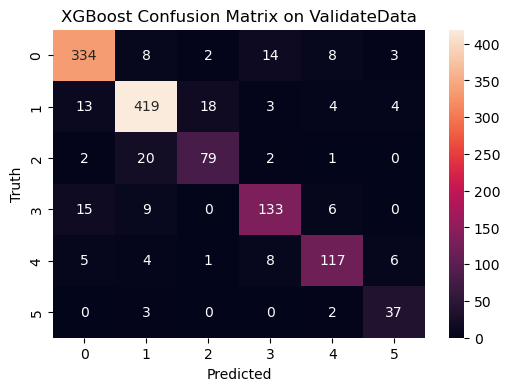

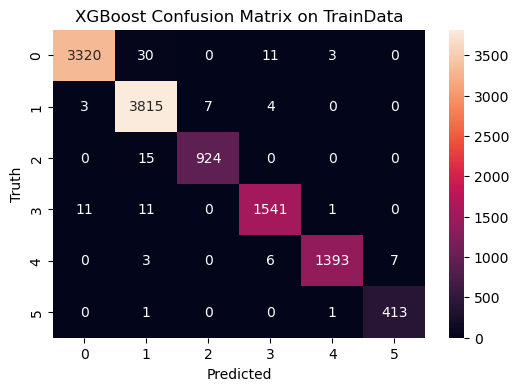

In [131]:
see_confusion_matrix(best_estimators_imb["XGBoost"],"XGBoost Confusion Matrix on ValidateData",y_val_imb,X_val_imb)
see_confusion_matrix(best_estimators_imb["XGBoost"],"XGBoost Confusion Matrix on TrainData",y_train_imb,X_train_imb)

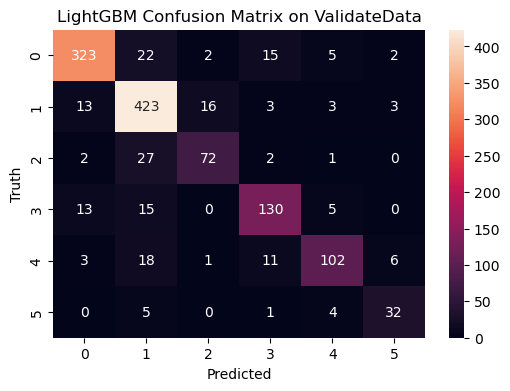

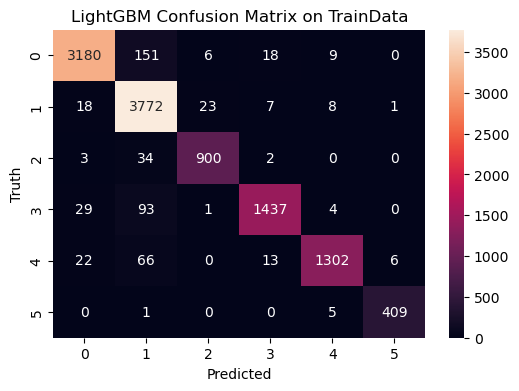

In [132]:
see_confusion_matrix(best_estimators_imb["LightGBM"],"LightGBM Confusion Matrix on ValidateData",y_val_imb,X_val_imb)
see_confusion_matrix(best_estimators_imb["LightGBM"],"LightGBM Confusion Matrix on TrainData",y_train_imb,X_train_imb)

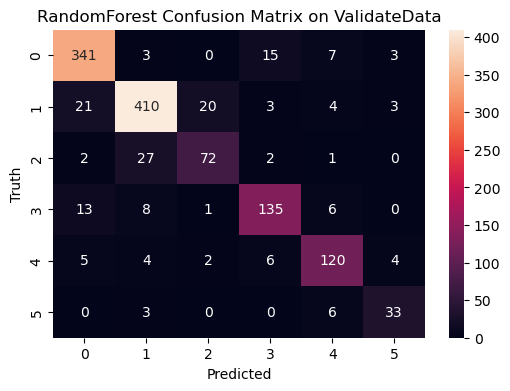

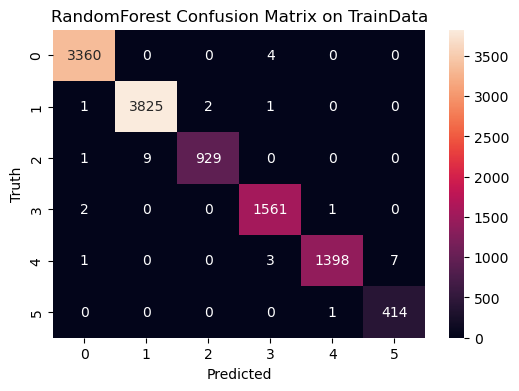

In [120]:
see_confusion_matrix(best_estimators_imb["RandomForest"],"RandomForest Confusion Matrix on ValidateData",y_val_imb,X_val_imb)
see_confusion_matrix(best_estimators_imb["RandomForest"],"RandomForest Confusion Matrix on TrainData",y_train_imb,X_train_imb)

> **XGBoost classifier** performs well on the imbalanced data at accuracy of 89% , throught the confusion matrix we can see that for both the test data , and train data . The maximum True positive predicted values than the other two classifier(Logistic Regression , RandomForest)

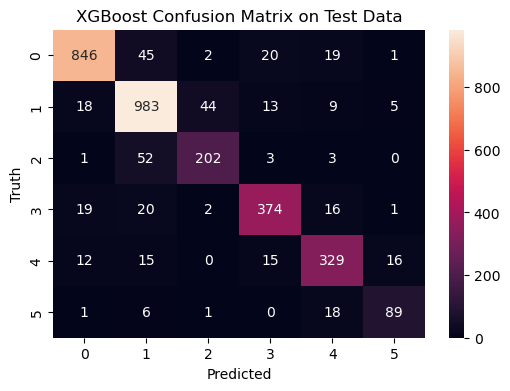

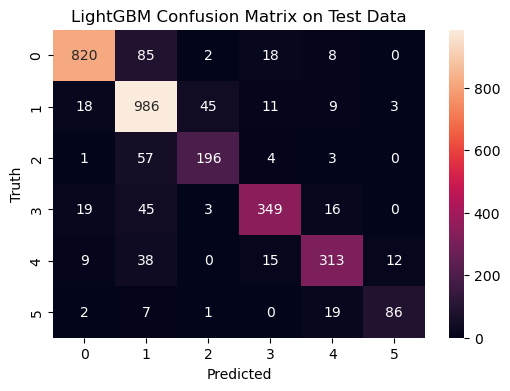

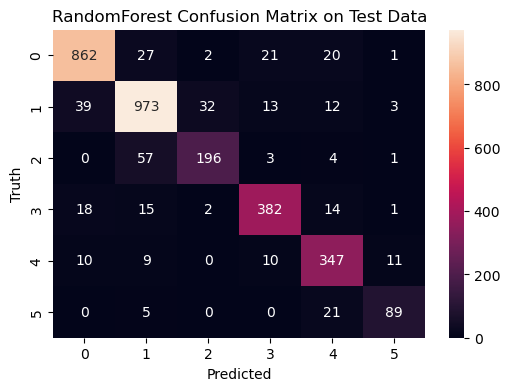

In [122]:
see_confusion_matrix(best_estimators_imb["XGBoost"],"XGBoost Confusion Matrix on Test Data",y_test_imb,X_test_imb)
see_confusion_matrix(best_estimators_imb["LightGBM"],"LightGBM Confusion Matrix on Test Data",y_test_imb,X_test_imb)
see_confusion_matrix(best_estimators_imb["RandomForest"],"RandomForest Confusion Matrix on Test Data",y_test_imb,X_test_imb)

In [126]:
## classification report of XGBoost Classifier on Test data dataset
xgb_clf_report=classification_report(y_val_imb,best_estimators_imb["XGBoost"].predict(X_val_imb))
lgb_clf_report=classification_report(y_val_imb,best_estimators_imb["LightGBM"].predict(X_val_imb))
rf_clf_report=classification_report(y_val_imb,best_estimators_imb["RandomForest"].predict(X_val_imb))

### XGBoost classification report on Validate data

In [127]:
print(xgb_clf_report)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       369
           1       0.90      0.91      0.91       461
           2       0.79      0.76      0.77       104
           3       0.83      0.82      0.82       163
           4       0.85      0.83      0.84       141
           5       0.74      0.88      0.80        42

    accuracy                           0.87      1280
   macro avg       0.84      0.85      0.84      1280
weighted avg       0.87      0.87      0.87      1280



### LightGBoost classification report on Validate data

In [128]:
print(lgb_clf_report)

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       369
           1       0.83      0.92      0.87       461
           2       0.79      0.69      0.74       104
           3       0.80      0.80      0.80       163
           4       0.85      0.72      0.78       141
           5       0.74      0.76      0.75        42

    accuracy                           0.85      1280
   macro avg       0.82      0.79      0.81      1280
weighted avg       0.85      0.85      0.84      1280



### Random Forest classification report on Validate data

In [129]:
print(rf_clf_report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       369
           1       0.90      0.89      0.90       461
           2       0.76      0.69      0.72       104
           3       0.84      0.83      0.83       163
           4       0.83      0.85      0.84       141
           5       0.77      0.79      0.78        42

    accuracy                           0.87      1280
   macro avg       0.83      0.83      0.83      1280
weighted avg       0.87      0.87      0.87      1280



### Classifiers with the balanced data

The below set of classifier works well on the balanced dataset 
- Linear models like
  - ***Logistic Regression*** - Excels when the data is linearly separable, meaning clear decision boundaries exist between classes 
  - ***Support Vector Machine*** - They find the optimal hyperplane that maximizes the margin between classes in the feature space.Works well on linearly separable data.

Some other classifiers like
- **KNearest neighbours** - This is a non-parametric algorithm that classifies data points based on the majority class of their k nearest neighbors
- **NaiveBayes** - For Text Classification, ability to handle high-dimensional sparse data (many features with mostly zeros).



##### using Grid Search to obtain the best classifier for balanced data

In [56]:
classifiers = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(class_weight='balanced', random_state=42), # can works even well for imbalanced data too
    'KNN': KNeighborsClassifier(n_neighbors=5),  
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'NaiveBayes': MultinomialNB(),
    'LightGBM': LGBMClassifier(objective='multiclass', num_class=len(class_counts), random_state=42),
    'LogisticRegression': LogisticRegression(solver='liblinear', multi_class='auto', random_state=42),
    'XGBoost': XGBClassifier(objective='multi:softprob', random_state=42)  
}



In [57]:
param_grid = {
    'DecisionTree': {'max_depth': [3, 5, 8,10,20,30]},
    'SVM': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'RandomForest': {'n_estimators': [50, 100, 200]},
    'LightGBM': {'learning_rate': [0.01, 0.1, 1]},  # LightGBM parameters
    'NaiveBayes': {'alpha': [1, 2, 3, 5, 10], 'fit_prior': [True, False]},
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}  # XGBoost parameters
}


In [59]:

scores = []
best_estimators = {}

for model_name,model in classifiers.items():
    clf=GridSearchCV(classifiers[model_name],param_grid[model_name],scoring='accuracy', cv=5)
    
    clf.fit(X_train_syn, y_train_syn)  # Use balanced train dataset

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[model_name] = clf.best_estimator_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42359
[LightGBM] [Info] Number of data points in the train set: 18530, number of used features: 1357
[LightGBM] [Info] Start training from score -1.797713
[LightGBM] [Info] Start training from score -1.791220
[LightGBM] [Info] Start training from score -1.783483
[LightGBM] [Info] Start training from score -1.787666
[LightGBM] [Info] Start training from score -1.798365
[LightGBM] [Info] Start training from score -1.792191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.307610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42289
[LightGBM] [Info] Number of data points in the train set: 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.387507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42322
[LightGBM] [Info] Number of data points in the train set: 18531, number of used features: 1347
[LightGBM] [Info] Start training from score -1.797442
[LightGBM] [Info] Start training from score -1.791274
[LightGBM] [Info] Start training from score -1.783537
[LightGBM] [Info] Start training from score -1.788043
[LightGBM] [Info] Start training from score -1.798419
[LightGBM] [Info] Start training from score -1.791921
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42336
[LightGBM] [Info] Number of data points in the train set: 18531, number of used features: 1353
[LightGBM] [Info] Start training from score -1.797442
[LightGBM] [Info] Start training from score -1.791274
[LightGBM] [Info] Start training from score -1.783537
[LightGBM] [Info] Start training from score -1.787720
[LightGBM] [Info] Start training from score -1.798419
[LightGBM] [Info] Start training from score -1.792245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

In [60]:

output_df=pd.DataFrame(scores,columns=['model','best_score','best_params'])
output_df.sort_values(by="best_score",ascending=False)

,model,best_score,best_params
1,SVM,0.944826,{'C': 10}
6,LogisticRegression,0.938566,{'C': 10}
7,XGBoost,0.934724,"{'learning_rate': 1, 'n_estimators': 200}"
3,RandomForest,0.930104,{'n_estimators': 200}
5,LightGBM,0.927557,{'learning_rate': 0.1}
4,NaiveBayes,0.912360,"{'alpha': 1, 'fit_prior': False}"
2,KNN,0.734490,{'n_neighbors': 3}
0,DecisionTree,0.454820,{'max_depth': 30}


In [61]:
output_df.to_csv('D:\Sentiment_InfosysIntern\lakshita\SentimentAnalysis-TextClassification\model_bestparam_balanced_data.csv', index=False)

In [62]:
report_df = pd.DataFrame()
index=0
for model_name,clf in best_estimators.items():
    cr = classification_report(y_test_syn, clf.predict(X_test_syn), output_dict=True)
    cr['weighted avg']['model']=model_name
    cr['weighted avg']['accuracy']=cr['accuracy'] 
    # accuracy does not comes under weighted avg but for the sack of report adding accuracy too
    report_df=pd.concat([report_df,pd.DataFrame(cr['weighted avg'],index=[index])])
    index+=1
 

In [63]:
report_df.sort_values(by="accuracy",ascending=False)

,precision,recall,f1-score,support,model,accuracy
1,0.957480,0.957420,0.957419,6435.0,SVM,0.957420
6,0.948144,0.948096,0.947805,6435.0,LogisticRegression,0.948096
7,0.944359,0.944211,0.944202,6435.0,XGBoost,0.944211
5,0.942914,0.942502,0.942329,6435.0,LightGBM,0.942502
3,0.940867,0.940637,0.940068,6435.0,RandomForest,0.940637
4,0.918304,0.917949,0.917362,6435.0,NaiveBayes,0.917949
2,0.829583,0.757110,0.734768,6435.0,KNN,0.757110
0,0.600085,0.454235,0.383799,6435.0,DecisionTree,0.454235


In [64]:
report_df=pd.merge(report_df,output_df , on='model', how='inner')
report_df

,precision,recall,f1-score,support,model,accuracy,best_score,best_params
0,0.600085,0.454235,0.383799,6435.0,DecisionTree,0.454235,0.454820,{'max_depth': 30}
1,0.957480,0.957420,0.957419,6435.0,SVM,0.957420,0.944826,{'C': 10}
2,0.829583,0.757110,0.734768,6435.0,KNN,0.757110,0.734490,{'n_neighbors': 3}
3,0.940867,0.940637,0.940068,6435.0,RandomForest,0.940637,0.930104,{'n_estimators': 200}
4,0.918304,0.917949,0.917362,6435.0,NaiveBayes,0.917949,0.912360,"{'alpha': 1, 'fit_prior': False}"
5,0.942914,0.942502,0.942329,6435.0,LightGBM,0.942502,0.927557,{'learning_rate': 0.1}
6,0.948144,0.948096,0.947805,6435.0,LogisticRegression,0.948096,0.938566,{'C': 10}
7,0.944359,0.944211,0.944202,6435.0,XGBoost,0.944211,0.934724,"{'learning_rate': 1, 'n_estimators': 200}"


In [65]:
report_df.to_csv('D:\Sentiment_InfosysIntern\lakshita\SentimentAnalysis-TextClassification\model_report_balanced_data.csv')

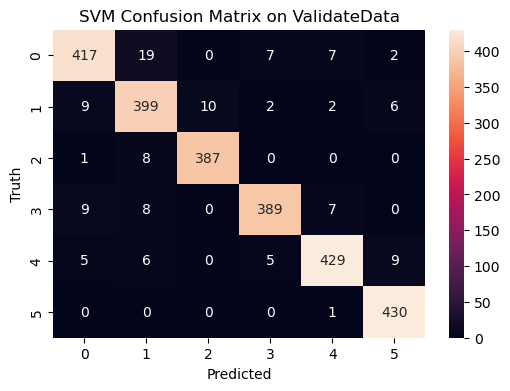

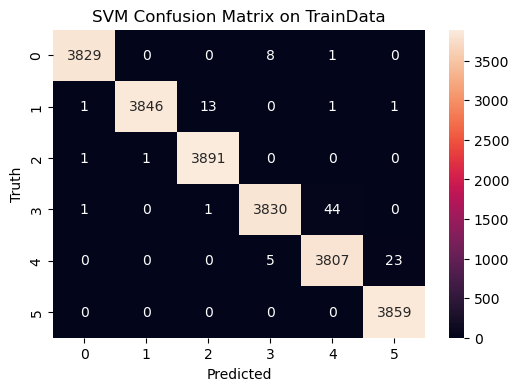

In [130]:
see_confusion_matrix(best_estimators["SVM"],"SVM Confusion Matrix on ValidateData",y_val_syn,X_val_syn)
see_confusion_matrix(best_estimators["SVM"],"SVM Confusion Matrix on TrainData",y_train_syn,X_train_syn)

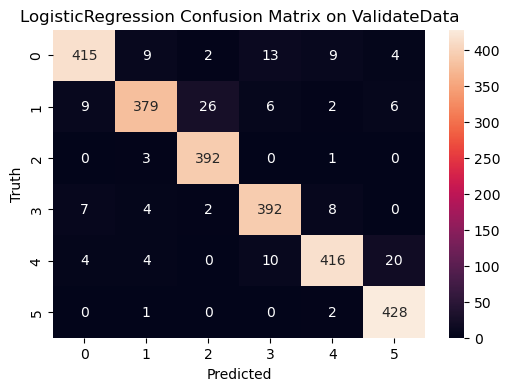

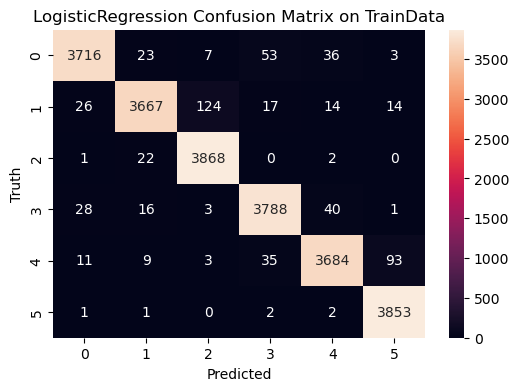

In [133]:
see_confusion_matrix(best_estimators["LogisticRegression"],"LogisticRegression Confusion Matrix on ValidateData",y_val_syn,X_val_syn)
see_confusion_matrix(best_estimators["LogisticRegression"],"LogisticRegression Confusion Matrix on TrainData",y_train_syn,X_train_syn)

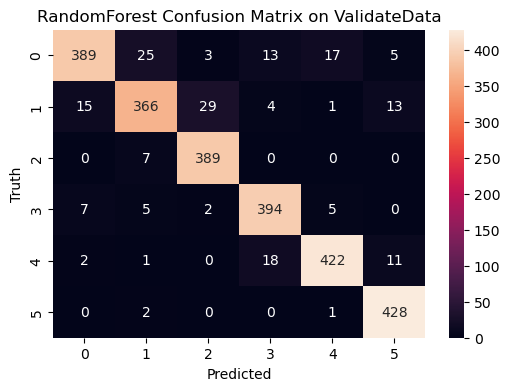

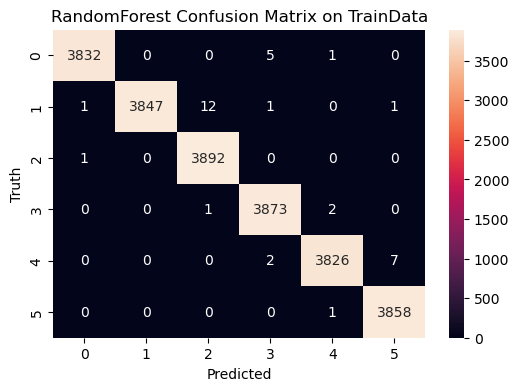

In [134]:
see_confusion_matrix(best_estimators["RandomForest"],"RandomForest Confusion Matrix on ValidateData",y_val_syn,X_val_syn)
see_confusion_matrix(best_estimators["RandomForest"],"RandomForest Confusion Matrix on TrainData",y_train_syn,X_train_syn)

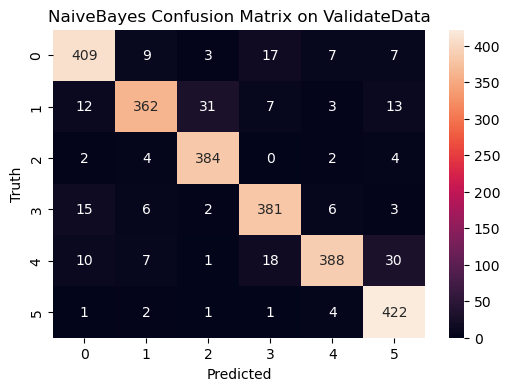

In [136]:
see_confusion_matrix(best_estimators["NaiveBayes"],"NaiveBayes Confusion Matrix on ValidateData",y_val_syn,X_val_syn)

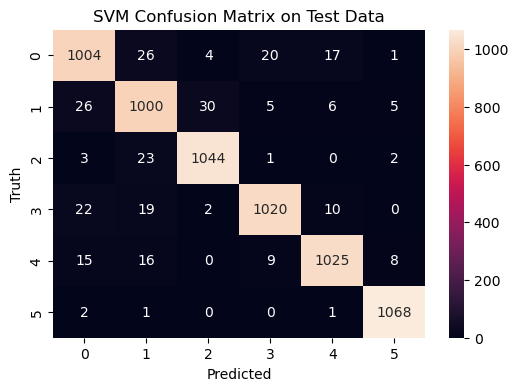

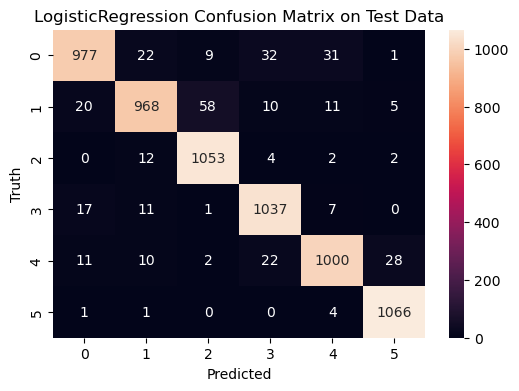

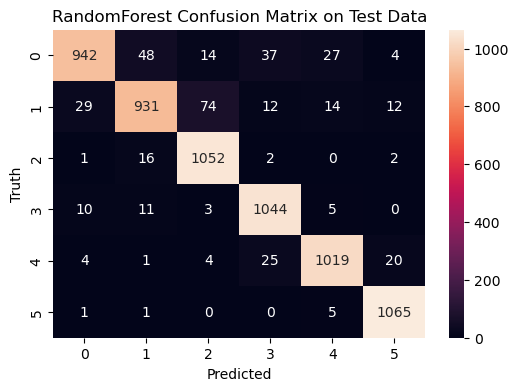

In [138]:
see_confusion_matrix(best_estimators["SVM"],"SVM Confusion Matrix on Test Data",y_test_syn,X_test_syn)
see_confusion_matrix(best_estimators["LogisticRegression"],"LogisticRegression Confusion Matrix on Test Data",y_test_syn,X_test_syn)
see_confusion_matrix(best_estimators["RandomForest"],"RandomForest Confusion Matrix on Test Data",y_test_syn,X_test_syn)

> **Support Vector Machine** has performed very well on the classification with accuracy of 95% , which is twice as more than the DecisionTree classifier(45% accuracy) . Hence as compared to the performance metrics as other classifier let choose SVM as our classification model

In [139]:
svm_clf_report=classification_report(y_val_syn,best_estimators["SVM"].predict(X_val_syn))
lr_clf_report=classification_report(y_val_syn,best_estimators["LogisticRegression"].predict(X_val_syn))
rf_clf_report=classification_report(y_val_syn,best_estimators["RandomForest"].predict(X_val_syn))

### SVM classification report on Validate dataset

In [140]:
print(svm_clf_report)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       452
           1       0.91      0.93      0.92       428
           2       0.97      0.98      0.98       396
           3       0.97      0.94      0.95       413
           4       0.96      0.94      0.95       454
           5       0.96      1.00      0.98       431

    accuracy                           0.95      2574
   macro avg       0.95      0.95      0.95      2574
weighted avg       0.95      0.95      0.95      2574



### Logistic Regression Classification report on Validate dataset

In [141]:
print(lr_clf_report)

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       452
           1       0.95      0.89      0.92       428
           2       0.93      0.99      0.96       396
           3       0.93      0.95      0.94       413
           4       0.95      0.92      0.93       454
           5       0.93      0.99      0.96       431

    accuracy                           0.94      2574
   macro avg       0.94      0.94      0.94      2574
weighted avg       0.94      0.94      0.94      2574



### Random Forest Classification report on Validate dataset

In [142]:
print(rf_clf_report)

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       452
           1       0.90      0.86      0.88       428
           2       0.92      0.98      0.95       396
           3       0.92      0.95      0.94       413
           4       0.95      0.93      0.94       454
           5       0.94      0.99      0.96       431

    accuracy                           0.93      2574
   macro avg       0.93      0.93      0.93      2574
weighted avg       0.93      0.93      0.93      2574



## Conclusion

>  Since on the classification report , **XGBoost algorithm works very well on the imbalanced dataset as well** , with the parameters as
**learing rate as 1** , and **n_estimators as 200**

In [146]:
report_df_imb.sort_values(by="accuracy",ascending=False)

,precision,recall,f1-score,support,model,accuracy,best_score,best_params
1,0.890363,0.890312,0.889894,3200.0,RandomForest,0.890312,0.880035,{'n_estimators': 200}
3,0.882729,0.882188,0.882158,3200.0,XGBoost,0.882188,0.883507,"{'learning_rate': 1, 'n_estimators': 100}"
2,0.863175,0.859375,0.859327,3200.0,LightGBM,0.859375,0.831337,{'learning_rate': 0.1}
0,0.482568,0.427500,0.325577,3200.0,DecisionTree,0.427500,0.426997,"{'criterion': 'gini', 'max_depth': 30}"
4,0.142690,0.334375,0.174124,3200.0,AdaBoost,0.334375,0.333507,"{'algorithm': 'SAMME', 'learning_rate': 1, 'n_..."


In [155]:
output_df_imb.query('model == "XGBoost"') # best score based on GridSearchCv accuracy

,model,best_score,best_params
3,XGBoost,0.883507,"{'learning_rate': 1, 'n_estimators': 100}"


> On the Balanced dataset with the performance level of **95% by using SVM classifier** , with **parameters as C=10 , kernal=linear**  

In [148]:

report_df.sort_values(by="accuracy",ascending=False)

,precision,recall,f1-score,support,model,accuracy,best_score,best_params
1,0.957480,0.957420,0.957419,6435.0,SVM,0.957420,0.944826,{'C': 10}
6,0.948144,0.948096,0.947805,6435.0,LogisticRegression,0.948096,0.938566,{'C': 10}
7,0.944359,0.944211,0.944202,6435.0,XGBoost,0.944211,0.934724,"{'learning_rate': 1, 'n_estimators': 200}"
5,0.942914,0.942502,0.942329,6435.0,LightGBM,0.942502,0.927557,{'learning_rate': 0.1}
3,0.940867,0.940637,0.940068,6435.0,RandomForest,0.940637,0.930104,{'n_estimators': 200}
4,0.918304,0.917949,0.917362,6435.0,NaiveBayes,0.917949,0.912360,"{'alpha': 1, 'fit_prior': False}"
2,0.829583,0.757110,0.734768,6435.0,KNN,0.757110,0.734490,{'n_neighbors': 3}
0,0.600085,0.454235,0.383799,6435.0,DecisionTree,0.454235,0.454820,{'max_depth': 30}


In [154]:
output_df.query('model == "SVM"')

,model,best_score,best_params
1,SVM,0.944826,{'C': 10}


Mean absolute error for SVM and XGBoost

In [308]:
print("Mean Absolute Error for XGBoost")
print("on Validate data",mean_absolute_error(y_val_imb,best_estimators_imb["XGBoost"].predict(X_val_imb)))
print("on Test Data",mean_absolute_error(y_test_imb,best_estimators_imb["XGBoost"].predict(X_test_imb)))

Mean Absolute Error for XGBoost
on Validate data 0.25390625
on Test Data 0.2121875


In [309]:
print("Mean Absolute Error for SVM")
print("on Validate data",mean_absolute_error(y_val_syn,best_estimators["SVM"].predict(X_val_syn)))
print("on Test data",mean_absolute_error(y_test_syn,best_estimators["SVM"].predict(X_test_syn)))

Mean Absolute Error for SVM
on Validate data 0.0947940947940948
on Test data 0.08749028749028749


> **Note** For the above results , **Random forest** works well on both type of datasets(**balanced accuracy as 94%**/ **imbalanced accuracy as 89%**) 

### Lets try out the classifier

In [306]:
message="I do not like the daily updation messages!" # text input
clean_message=data_cleaning(message) # clean data
vect= TfidfVectorizer(max_features=2000)  # vectorizer
fea=vect.fit_transform([clean_message]) 
# to arrange the features 
n1=fea.toarray() 
feature=np.append(n1,np.zeros((1,2000-n1.shape[1])),axis=1)  # trained with 2000 features hence resizing the matrix with zeros

prediction = best_estimators["RandomForest"].predict(feature)[0]  # predict the output with features
predicted_emotion = emotion_labels[prediction]
print("Predicted emotion for the message:", predicted_emotion) 

Predicted emotion for the message: anger
